In [73]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from tensorflow.data import TFRecordDataset
from kaggle_datasets import KaggleDatasets
import torch.nn as nn
from torch.utils.data import Dataset
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

## Brief description of the problem and data (5 pts)

Computer vision has advanced tremendously in recent years and GANs are now capable of mimicking objects in a very convincing way. But creating museum-worthy masterpieces is thought of to be, well, more art than science. So can (data) science, in the form of GANs, trick classifiers into believing you’ve created a true Monet?

A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

In [66]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*[256, 256], 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord)
    return dataset
def visualize_images(image_set):
    plt.figure(figsize = (10, 10))
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(image_set[i] * 0.5 + 0.5)
        plt.axis("off")

In [67]:
GCS_PATH = KaggleDatasets().get_gcs_path()
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

In [68]:
monet_ds = load_dataset(MONET_FILENAMES).batch(32)
photo_ds = load_dataset(PHOTO_FILENAMES).batch(32)

sample_monet = next(iter(monet_ds))

In [69]:
sample_monet.shape

TensorShape([32, 256, 256, 3])

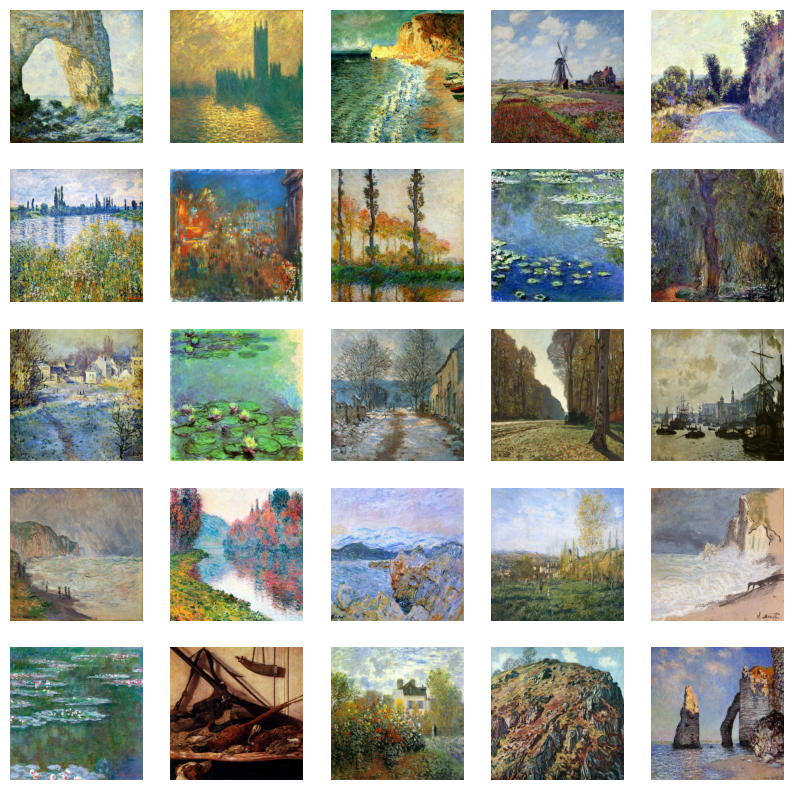

In [70]:
visualize_images(sample_monet)

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [74]:
class MonetPhotoDataSet(Dataset):
    def __init__(self, root_monet, root_photo, transform=None):
        self.root_monet = root_monet
        self.root_photo = root_photo
        self.transform = transform

        self.monet_images = os.listdir(root_monet)
        self.photo_images = os.listdir(root_photo)
        self.dataset_len = max(len(self.monet_images), len(self.photo_images)) 
        self.monet_len = len(self.monet_images)
        self.photo_len = len(self.photo_images)

    def __len__(self):
        return self.dataset_len

    def __getitem__(self, index):
        monet_img = self.monet_images[index % self.monet_len]
        photo_img = self.photo_images[index % self.photo_len]

        monet_path = os.path.join(self.root_monet, monet_img)
        photo_path = os.path.join(self.root_photo, photo_img)

        monet_img = np.array(Image.open(monet_path).convert("RGB"))
        photo_img = np.array(Image.open(photo_path).convert("RGB"))

        if self.transform:
            augmentations = self.transform(image=zebra_img, image0=horse_img)
            monet_img = augmentations["image"]
            photo_img = augmentations["image0"]

        return monet_img, photo_img


## Model Architecture

I think CycleGAN would work great . The architure have 2 generator and 2 discriminator. Generator 1 converts photos to monet and Generator 2 convert the monet painting generated from generator 1 back to photo. There is a loss function to compare the original photo to the photo that has gone through the generators. 

## Discriminator

In [75]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size = 4,
                stride = stride,
                padding = 1,
                bias=True,
                padding_mode="reflect"),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True))

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect"),
            nn.LeakyReLU(0.2, inplace=True))

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            stride = 1 if feature == features[-1] else 2
            layer = Block(in_channels, feature, stride)
            layers.append(layer)
            in_channels = feature
        
        last_layer = nn.Conv2d(in_channels,1, kernel_size=4,stride=1,padding=1,padding_mode="reflect")
        layers.append(last_layer)
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))

## Generator

In [72]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 
                      out_channels, 
                      padding_mode="reflect", 
                      **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, 
                                    out_channels, 
                                    **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity())

    def forward(self, x):
        return self.conv(x)


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, 
                      channels, 
                      kernel_size=3, 
                      padding=1),
            ConvBlock(channels, 
                      channels, 
                      use_act=False, 
                      kernel_size=3, 
                      padding=1))

    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels,
                      num_features,
                      kernel_size=7,
                      stride=1,
                      padding=3,
                      padding_mode="reflect"),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True))
        self.down_blocks = nn.ModuleList(
            [ConvBlock(num_features, 
                       num_features * 2, 
                       kernel_size=3, 
                       stride=2, 
                       padding=1),
             ConvBlock(num_features * 2,
                       num_features * 4,
                       kernel_size=3,
                       stride=2,
                       padding=1)])
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)])
        self.up_blocks = nn.ModuleList(
            [ConvBlock(num_features * 4,
                       num_features * 2,
                       down=False,
                       kernel_size=3,
                       stride=2,
                       padding=1,
                       output_padding=1),
             ConvBlock(num_features * 2,
                       num_features * 1,
                       down=False,
                       kernel_size=3,
                       stride=2,
                       padding=1,
                       output_padding=1)])

        self.last = nn.Conv2d(num_features * 1,
                              img_channels,
                              kernel_size=7,
                              stride=1,
                              padding=3,
                              padding_mode="reflect")

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))

# Cycle GAN

## Results and Analysis

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

## Conclusion

I was not able to finish the assignemnt, so I just submit what I've done 